In [1]:
import sys 
BASE_DIR="/home/asirvent/second_CTA_analysis"
sys.path.append(f"{BASE_DIR}/src/CTA-data-analisis-library/")
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import re 
import glob 
import tensorflow as tf 
import seaborn as sns
import pandas as pd
import gc
import pickle 
import ast
from sklearn.metrics import confusion_matrix

from matplotlib.lines import Line2D

#propias
import unzipdata_and_first_treatments as manipulate
import loaddata4use
import model_creation_functions as models
import model_results_representations
# %%
PATH_TXT=f"/home/asirvent/SimTelArray_2022_05"

RESULTS_DIR=f"/home/asirvent/second_CTA_analysis/notebooks/results_UGR"


2023-07-16 12:46:17.287020: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.1 when it was built against 1.14.0, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
# %%
# voy a cargar toda la info de los txt para cada elemento 
elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
aux2=[]
for i , elemento in enumerate(elementos):
    #dict_master[elemento]={}
    list_aux=glob.glob(f"{PATH_TXT}/extract_{elemento}/*.txt")
    list_aux=sorted(list_aux)

    for dir_aux in list_aux:
        run_aux=int(re.findall("(\d{3})\.txt",dir_aux)[0])
        tel_aux=int(re.findall("tel_(\d{1})_run",dir_aux)[0])
        #La idea es tener un diccionario enorme de todo lo que podemos necesitar para seleccionar el rango de todo y las distribuciones.  
        # Esto lo logramos con los datos de extract  
        array_aux=loaddata4use.extract_info_txt(dir_aux)
        if array_aux.size>0:
            aux2.append({"elemento":elemento,"run":run_aux,"tel":tel_aux,"energia":array_aux[:,2],"eventos":array_aux[:,0].astype(int)})
        else:
            aux2.append({"elemento":elemento,"run":run_aux,"tel":tel_aux,"energia":np.nan,"eventos":np.nan})
df_final=pd.DataFrame.from_dict(aux2)
df_final

,elemento,run,tel,energia,eventos
0,gamma,1,1,"[0.1087, 0.0616, 0.0904, 4.5563, 0.3297, 0.057...","[800, 1200, 1700, 2300, 3600, 4200, 4300, 5200..."
1,gamma,2,1,"[0.0957, 0.0321, 0.2691, 0.0559, 0.2708, 1.74,...","[100, 400, 700, 2100, 2500, 3100, 3300, 3500, ..."
2,gamma,3,1,NaN,NaN
3,gamma,4,1,"[0.0424, 0.1245, 0.0328, 0.0341, 1.0774, 0.070...","[100, 200, 700, 1800, 2200, 2600, 3500, 3900, ..."
4,gamma,5,1,"[0.2236, 0.2041, 0.0704, 0.1473, 0.0458, 0.095...","[200, 600, 800, 1000, 1700, 1900, 3500, 3600, ..."
...,...,...,...,...,...
9628,silicon,356,4,"[4.4503, 4.3298, 3.8065, 4.5505, 4.7329, 3.959...","[4100, 6900, 7800, 10100, 10200, 11600, 13800,..."
9629,silicon,357,4,"[3.2706, 4.7084, 4.9035, 3.0785, 3.5371, 4.756...","[400, 1200, 2100, 7400, 9300, 10700, 11700, 13..."
9630,silicon,358,4,"[4.8596, 4.8966, 2.2676, 4.0688, 4.3492, 2.959...","[700, 2700, 8300, 9000, 15400, 16300, 20500, 2..."
9631,silicon,359,4,"[2.1081, 2.8272, 3.8519, 2.8368, 4.525, 3.0555...","[1700, 3900, 5300, 6700, 11300, 12400, 14300, ..."


In [3]:

# %%
def f_get_comon_events(df):
    all_eventos=np.concatenate(df["eventos"].to_numpy())
    event,count=np.unique(all_eventos,return_counts=True)
    all_energias=np.concatenate(df["energia"].to_numpy())
    energias_eventos_comunes=[]
    for i in event[count==4]:
        indx=np.argwhere(i==all_eventos)
        if np.unique(all_energias[indx]).size!=1:
            print("Algo ha pasado con el evento i, no coinciden las energias")
        energias_eventos_comunes.append(all_energias[indx[0]][0])
    return pd.DataFrame({"eventos":event[count==4],"energia":energias_eventos_comunes})

# %%
df_common_events=df_final.dropna().groupby(["elemento","run"]).apply(f_get_comon_events).droplevel(2).reset_index()#.to_frame()
df_common_events


,elemento,run,eventos,energia
0,electron,1,55300,0.1307
1,electron,1,74000,0.1603
2,electron,1,82500,0.8038
3,electron,1,109700,0.6685
4,electron,1,152100,0.2394
...,...,...,...,...
603177,silicon,360,1796100,4.8594
603178,silicon,360,1798300,2.8470
603179,silicon,360,1798500,4.9862
603180,silicon,360,1798800,4.4138


In [4]:
df_lista_runs=pd.read_csv(f"{RESULTS_DIR}/runs_train_test_3.csv",index_col=[0])
df_lista_runs.loc["list_runs"]=df_lista_runs["list_runs"].apply(ast.literal_eval)

df_lista_runs=df_lista_runs.iloc[:-1] # se crea una fila que no se de donde sale.

In [5]:
df_lista_runs["list_runs"]=df_lista_runs["list_runs"].apply(lambda x : ast.literal_eval(x))
# %%
train_runs=df_lista_runs.loc[df_lista_runs["mode"]=="Train"].set_index("elemento")
train_runs=train_runs.loc[elementos].reset_index()
train_runs_list=list(train_runs["list_runs"].to_numpy())


# %%
test_runs=df_lista_runs.loc[df_lista_runs["mode"]=="Test"].set_index("elemento")
test_runs=test_runs.loc[elementos].reset_index()
test_runs_list=list(test_runs["list_runs"].to_numpy())


In [6]:
#sacar el número de enventos usados para el entrenamiento

#numero de runs usadas para el entrenamiento
print([len(i)for i in train_runs_list])
print([len(i)for i in test_runs_list])

#numero de eventos disponibles en esas runs 

for i, j in enumerate(df_lista_runs.elemento.unique()):
#electron train
    print(j, df_common_events.loc[(df_common_events["elemento"]==j)].loc[[True if k in test_runs_list[i] else False for k in df_common_events.loc[df_common_events["elemento"]==j,"run"]]].shape[0])

# #gmma train
# print(df_common_events.loc[(df_common_events["elemento"]=="gamma")].loc[[True if i in train_runs_list[0] else False for i in df_common_events.loc[df_common_events["elemento"]=="gamma","run"]]].shape[0])

# #electron test
# print(df_common_events.loc[(df_common_events["elemento"]=="electron")].loc[[True if i in test_runs_list[2] else False for i in df_common_events.loc[df_common_events["elemento"]=="electron","run"]]].shape[0])

# #gamma test
# print(df_common_events.loc[(df_common_events["elemento"]=="gamma")].loc[[True if i in test_runs_list[0] else False for i in df_common_events.loc[df_common_events["elemento"]=="gamma","run"]]].shape[0])

[75, 278, 343, 255, 347, 318, 287]
[20, 68, 87, 65, 87, 82, 73]
electron 3952
gamma 22670


helium 16826
iron 10648
nitrogen 17680
proton 13208
silicon 17316


In [7]:
df_common_events_renamed=df_common_events.rename(columns={"energia":"energy (TeV)"})

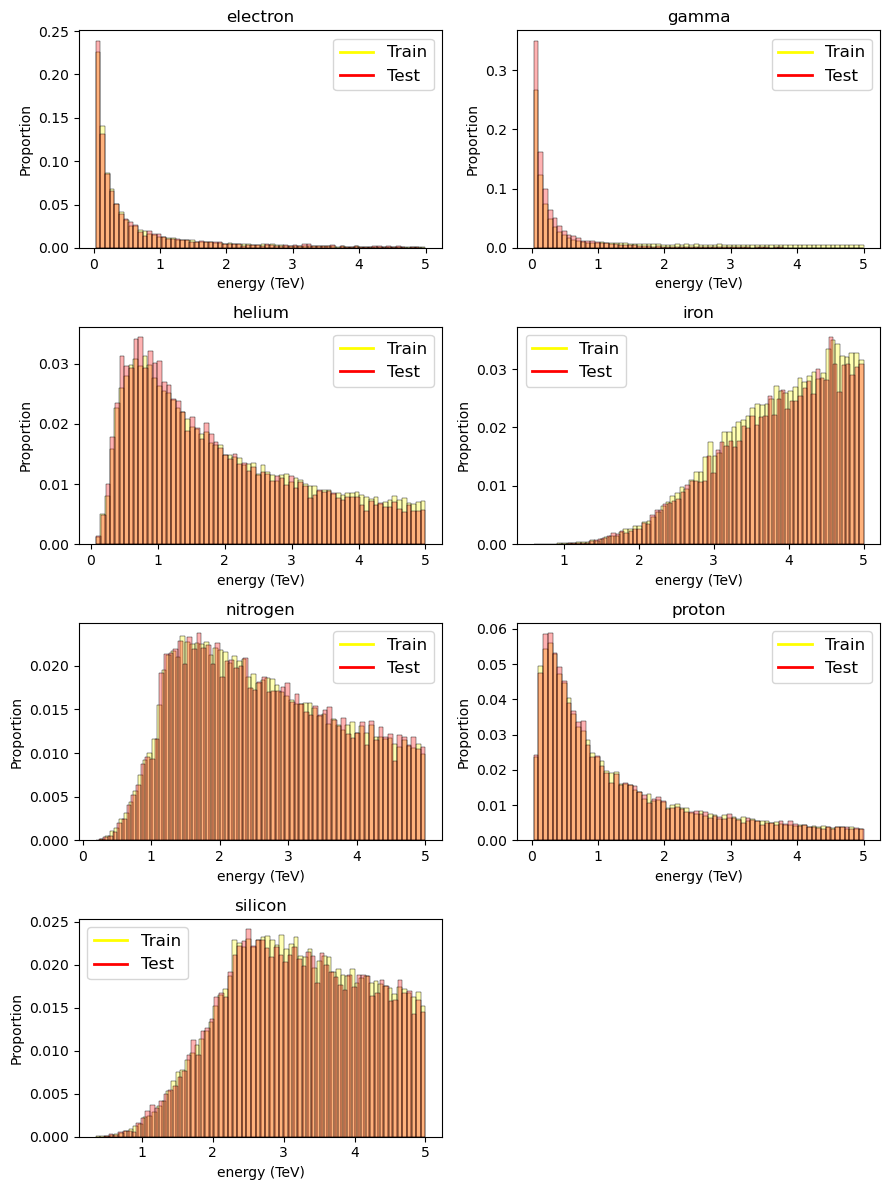

In [8]:
# Un poco de info sobre las PDF de la energía (TeV) en estos eventos
plt.figure(figsize=(9,12))

for i,j in enumerate(df_lista_runs.elemento.unique()):
    ax = plt.subplot(4, 2, i+1)
    sns.histplot(df_common_events_renamed.loc[(df_common_events_renamed["elemento"]==j)].loc[[True if k in train_runs_list[i] else False for k in df_common_events_renamed.loc[df_common_events_renamed["elemento"]==j,"run"]]], x="energy (TeV)", ax=ax, stat="proportion",color="yellow", alpha=0.3, bins=70)
    sns.histplot(df_common_events_renamed.loc[(df_common_events_renamed["elemento"]==j)].loc[[True if k in test_runs_list[i] else False for k in df_common_events_renamed.loc[df_common_events_renamed["elemento"]==j,"run"]]], x="energy (TeV)", stat="proportion",color="red", alpha=0.3, bins=70)
    custom_legend_3 = [Line2D([0], [0], color='yellow', lw=2),Line2D([0], [0], color='red', lw=2)]
    plt.legend(custom_legend_3, ['Train','Test'],fontsize=12)
    plt.title(j,fontsize=12)   



plt.tight_layout()
#plt.savefig(f"{RESULTS_DIR}/012_pdf_energias_traintest_2_vertical.png")

In [9]:
with open(f"{RESULTS_DIR}/hist_3.pickle","rb") as pick:
    hist= pickle.load(pick)
hist.keys()

dict_keys(['loss', 'acc', 'auc', 'mean_squared_error', 'val_loss', 'val_acc', 'val_auc', 'val_mean_squared_error'])

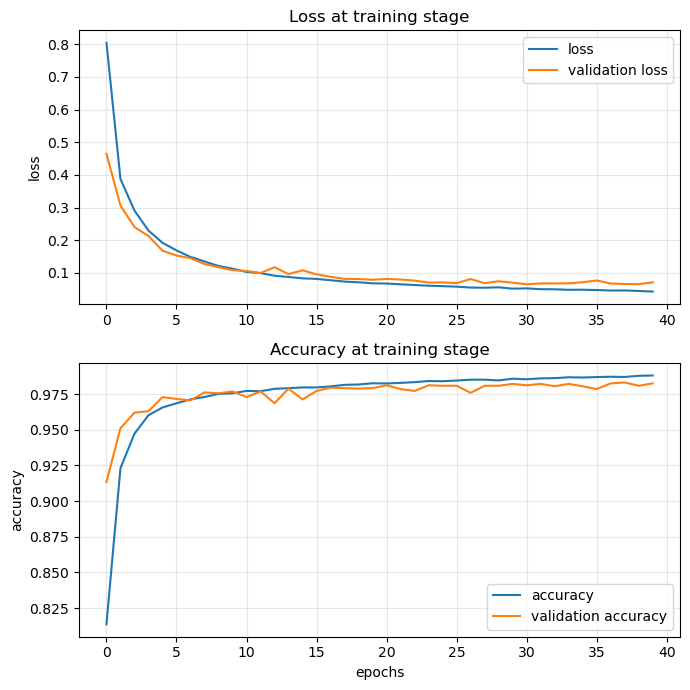

In [10]:
fig = plt.figure(figsize=(7,7))
ax=plt.subplot(2,1,1)
plt.plot(hist["loss"],label="loss")
plt.plot(hist["val_loss"],label="validation loss")
plt.legend()
plt.ylabel("loss")
plt.title("Loss at training stage")
plt.grid(alpha=0.3)
plt.subplot(2,1,2,sharex=ax)
plt.plot(hist["acc"],label="accuracy")
plt.plot(hist["val_acc"],label="validation accuracy")
plt.ylabel("accuracy")
plt.title("Accuracy at training stage")
plt.xlabel("epochs")

plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
#plt.savefig(f"{RESULTS_DIR}/012_loss_2.png")

In [11]:
runs_aux1=df_lista_runs.loc[df_lista_runs["mode"]=="Test",["elemento","list_runs"]]
#runs_aux1["list_runs"]=runs_aux1["list_runs"].apply(lambda x : ast.literal_eval(x))
runs_aux1

,elemento,list_runs
0,electron,"[249, 120, 22, 293, 345, 226, 187, 102, 89, 17..."
2,gamma,"[34, 44, 78, 50, 85, 21, 65, 25, 96, 13, 66, 7..."
4,helium,"[89, 27, 138, 177, 255, 158, 96, 86, 110, 142,..."
6,iron,"[226, 288, 367, 334, 242, 80, 104, 386, 109, 4..."
8,nitrogen,"[181, 124, 136, 263, 236, 254, 6, 153, 190, 24..."
10,proton,"[336, 235, 404, 405, 213, 36, 247, 287, 199, 2..."
12,silicon,"[294, 116, 31, 291, 257, 289, 260, 75, 316, 32..."


In [12]:
def cambiar_ejes_lista(lista):
    for i,j in enumerate(lista):
        lista[i]=np.swapaxes(j,1,2)
    return lista

In [13]:
mapping_labels={ j : i if i<=2 else 2 for i,j in enumerate(elementos)}
labels_mapped=[mapping_labels[i] for i in list(runs_aux1.elemento) ]
labels_mapped

[1, 0, 2, 2, 2, 2, 2]

In [14]:
PATH_NPY=f"{BASE_DIR}/data_full/elementos_npy"
x_train_list,x_test_list,y_train_list,y_test_list=loaddata4use.load_dataset_completo(PATH_NPY,list(runs_aux1.list_runs),[1,2,3,4],labels_asign=labels_mapped,elements=list(runs_aux1.elemento),pre_name_folders="npy_",test_size=0.01,same_quant="approx",verbose=True,fill=True,categorical=True)
x_train_list=cambiar_ejes_lista(x_train_list)

Load of names and common events
_______________
0 ;  Element:  electron  , Runs:  [249, 120, 22, 293, 345, 226, 187, 102, 89, 176, 33, 246, 15, 40, 193, 350, 310, 216, 71, 316, 172, 177, 349, 161, 369, 262, 360, 328, 367, 31, 6, 315, 339, 186, 329, 5, 69, 265, 84, 336, 74, 137, 338, 313, 4, 34, 370, 309, 76, 188, 214, 64, 364, 49, 113, 3, 212, 327, 50, 227, 52, 153, 160, 242, 250, 101, 229, 27]  Shape of common events (tels,common events):  (4, 274)
1 ;  Element:  electron  , Runs:  [249, 120, 22, 293, 345, 226, 187, 102, 89, 176, 33, 246, 15, 40, 193, 350, 310, 216, 71, 316, 172, 177, 349, 161, 369, 262, 360, 328, 367, 31, 6, 315, 339, 186, 329, 5, 69, 265, 84, 336, 74, 137, 338, 313, 4, 34, 370, 309, 76, 188, 214, 64, 364, 49, 113, 3, 212, 327, 50, 227, 52, 153, 160, 242, 250, 101, 229, 27]  Shape of common events (tels,common events):  (4, 232)
2 ;  Element:  electron  , Runs:  [249, 120, 22, 293, 345, 226, 187, 102, 89, 176, 33, 246, 15, 40, 193, 350, 310, 216, 71, 316, 172, 177, 3

In [50]:
#os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

In [15]:
modelo=tf.keras.models.load_model(f"{RESULTS_DIR}/test_3.h5")

2023-07-16 14:21:50.660167: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9648 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2023-07-16 14:21:50.661990: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9648 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5
2023-07-16 14:21:50.663548: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9648 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1c:00.0, compute capability: 7.5
2023-07-16 14:21:50.664762: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 9648 MB memory:  -> device: 3, name: NVIDIA GeForce RTX

In [16]:
y_pred=modelo.predict(x_train_list)

2023-07-16 14:22:16.755621: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-07-16 14:22:21.028823: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 195.82MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-07-16 14:22:21.028924: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 406.07MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-07-16 14:22:21.028961: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 406.07MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gain

3549/3549 [==============================] - 44s 9ms/step


In [17]:
#funcion que nos ayuda a mostar la matrix de confusion, needs seaborn as sns
def print_conf_matrix(matrix,elements=None,sin_diag=True,save_dir=None):
    if elements is None:
        elements=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    if sin_diag:
        for i in range(len(elements)):
            matrix[i,i]=0
    fig=plt.figure(figsize=(10,7))
    sns.heatmap(matrix,annot=True,annot_kws={'size':16},fmt=".3g")

    plt.yticks(np.arange(len(elements))+0.5,elements,fontsize=14,rotation=0);
    plt.xticks(np.arange(len(elements))+0.5,elements,fontsize=14,rotation=0);
    plt.title("True label in Y-axis, predicted label in X-axis", fontsize=15)
    if save_dir != None:
        plt.tight_layout()
        plt.savefig(save_dir)
    return fig

comp_and_diplay_conf_matrix(y_train_list,y_pred,elements=["gamma","electron","hadron"],sin_diag=False,save_dir=f"{RESULTS_DIR}/conf_matrix_1.png");
def comp_and_diplay_conf_matrix(y_test,y_predict,elements=None,sin_diag=True,norm="true",save_dir=None):
    matrix=confusion_matrix(np.argmax(y_test,axis=-1),np.argmax(y_predict,axis=-1),normalize=norm) #sklearn.metrics.confusion_matrix
    return print_conf_matrix(matrix,elements=elements,sin_diag=sin_diag,save_dir=save_dir)



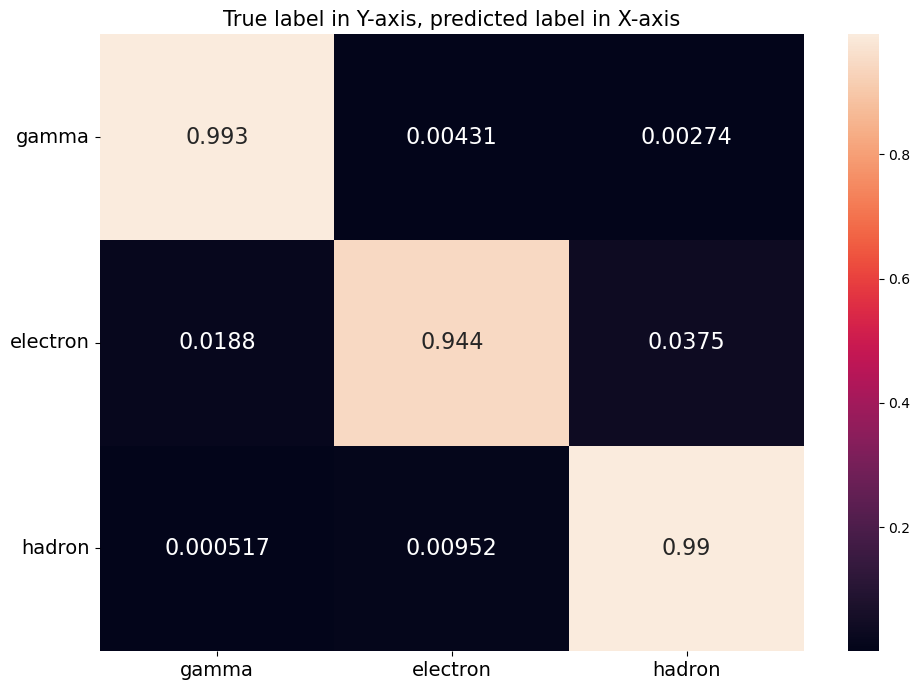

In [19]:
comp_and_diplay_conf_matrix(y_train_list,y_pred,elements=["gamma","electron","hadron"],sin_diag=False,save_dir=f"{RESULTS_DIR}/conf_matrix_1tels_3labels_ontest.png");